In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [3]:
torch.cuda.set_device(device)

In [4]:
from utils import load_cifar10, load_cifar100, load_tinyimagenet

In [5]:
# load cifar10 data
trainloader, testloader = load_cifar10(data_dir="../data/cifar10", batch_size=128, 
                                       test_batch = 128,train_shuffle=True)
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [6]:
from utils import train_valid_split

- MIA attack 할 때에는 attack net 이 10,000개의 cifar100 training data 만 사용
- 아래 cifar100 데이터로 나중에 attack net 학습 시에 사용했던 부분과 사용 안했던 부분을 나누어야 하기 때문에 stealloader 에서 일부 데이터만 사용
- MIA attack 을 위해서 cifar100의 attack net 학습 시에 사용했던 데이터와 사용하지 않은 validation data 를 저장해 두어야 함!

In [7]:
# load dataloader for steal
stealloader,st_testloader = load_cifar100(data_dir="../data/cifar100", batch_size=128, train_shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [8]:
# load tinyimagenet for outlier exposure
outlier_loader = load_tinyimagenet(data_dir="../data/tiny-imagenet-200",
                                   batch_size=128, train_shuffle=True)

# Steal Model 

## Attack comb net

- CombNet 에서 tau 설정 필요
- nb_stolen 으로 steal 시에 사용할 데이터 수 정할 수 있음

In [28]:
class args:
    save_dir = "../results"
    orig_model = "net_taylor.pth"
#     fake_model = "cifar_fake_random_net.pth"
    fake_model = "cifar_fake_taylor_swae.pth"
    tau = 0.5
    nb_stolen = 10000 # attack model 학습시 사용할 데이터 수
    st_trloader = "attnet_trloader.dl"
    st_valloader = "attnet_valloader.dl"
    att_epochs = 300
    att_model = str(tau)+"_cifar_att_net_comb.pth"

- attack net 학습을 위해서 아래와 같이 validation set 을 구분하고, st_trloader 에는 args.nb_stolen 만큼의 데이터가, st_valloader 에서는 args.nb_stolen 만큼의 데이터가 포함되게 됨
- st_trloader, st_valloader 는 나중에 MIA_attack 및 evaluation 을 위해서 저장해 둠!

In [10]:
st_trloader, st_valloader = train_valid_split(stealloader,args.nb_stolen*2)
torch.save(st_trloader, args.st_trloader)
torch.save(st_valloader, args.st_valloader)

total data: 20000


In [11]:
from cifar_models import Net, Net_logit, AttackNet
from utils import CombNet, CombNet_soft

In [12]:
import os
net = Net()
net.load_state_dict(torch.load(os.path.join(args.save_dir,args.orig_model),map_location='cpu'))
net_fake = Net()
net_fake.load_state_dict(torch.load(os.path.join(args.save_dir,args.fake_model),map_location='cpu'))
comb_net = CombNet_soft(net, net_fake, tau=args.tau)

In [13]:
from utils import train_stmodel_comb_hard_label, select_data,test_corr_model
att_net = AttackNet()
criterion_att = nn.CrossEntropyLoss()
optimizer_att = optim.SGD(att_net.parameters(), lr=0.001, momentum=0.9)

In [14]:
""" if we use the already trained model!! """
# att_net.load_state_dict(torch.load(os.path.join(args.save_dir,args.att_model),map_location='cpu'))
# st_trloader = torch.load(args.st_trloader)
# st_valloader = torch.load(args.st_valloader)

<All keys matched successfully>

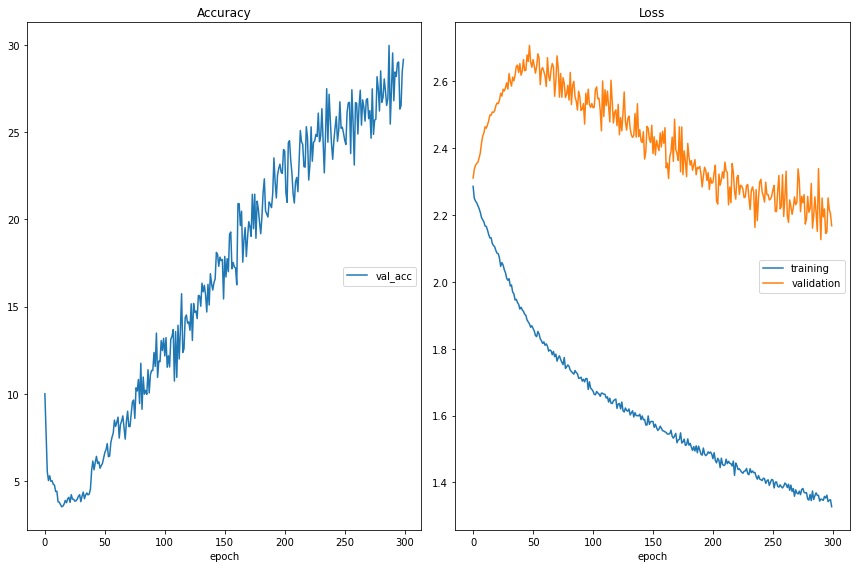

Accuracy
	val_acc          	 (min:    3.520, max:   29.980, cur:   29.180)
Loss
	training         	 (min:    1.327, max:    2.286, cur:    1.327)
	validation       	 (min:    2.127, max:    2.708, cur:    2.168)


In [205]:
att_net, logs_att = train_stmodel_comb_hard_label(st_trloader, att_net, criterion_att, optimizer_att, comb_net, 
                                       epochs=args.att_epochs, device=device, test_loader=testloader, 
                                         save_dir = args.save_dir, 
                                       save_model=args.att_model)

## test steal model

In [15]:
from utils import test_corr_model, Net_softmax
att_net_prob = Net_softmax(att_net)
criterion_att = nn.CrossEntropyLoss()
loss1, loss2, acc1, acc2, corr = test_corr_model(comb_net, att_net_prob, testloader, criterion_att, device)

Accuracy/Loss 1: 63.01/1.9311
Accuracy/Loss 2: 29.98/2.1669
Correspondence:  tensor(44.4100)


# Test MIA from att_net

## mia dataloader

In [16]:
from utils import prepare_MIAattack_loader

- prepare_MIAattack_loader 에서 인자는 차례대로 학습에 사용한 network, 학습에 사용한 데이터, 학습에 사용하지 않은 데이터 에 해당한다!

In [17]:
mia_trloader = prepare_MIAattack_loader(att_net_prob, st_trloader, st_valloader,device)

data shape: torch.Size([20000, 3082])
number of data for training and valid: 10000 10000


## train mia attack model

In [19]:
from cifar_models import Net_MIA

In [20]:
from utils import test_model, AverageVarMeter, train_mia_model

In [21]:
mia_att_net = Net_MIA()

In [22]:
mia_criterion = nn.BCELoss()
mia_optimizer = optim.Adam(mia_att_net.parameters())
mia_epochs = 30

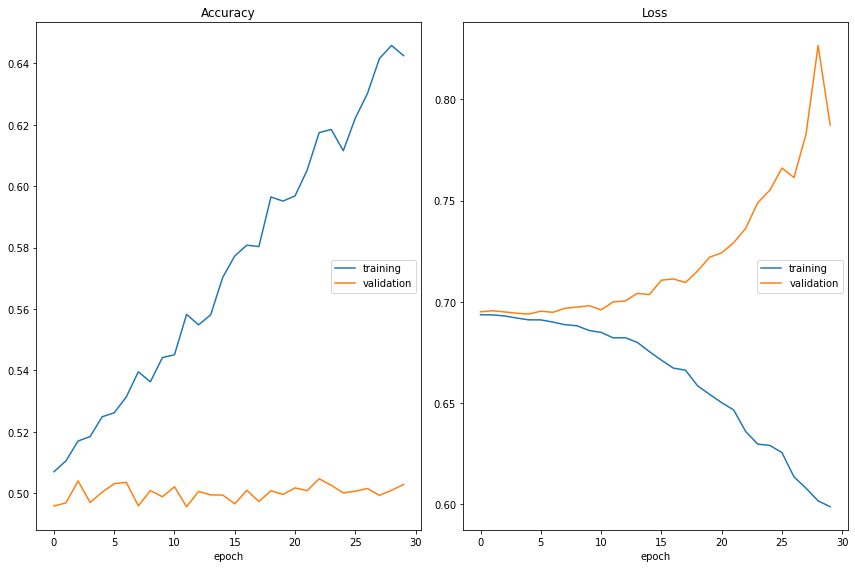

Accuracy
	training         	 (min:    0.507, max:    0.646, cur:    0.643)
	validation       	 (min:    0.496, max:    0.505, cur:    0.503)
Loss
	training         	 (min:    0.599, max:    0.694, cur:    0.599)
	validation       	 (min:    0.694, max:    0.827, cur:    0.787)


(Net_MIA(
   (lin1): Linear(in_features=3082, out_features=128, bias=True)
   (lin2): Linear(in_features=128, out_features=64, bias=True)
   (lin3): Linear(in_features=64, out_features=64, bias=True)
   (lin4): Linear(in_features=64, out_features=1, bias=True)
 ),
 {'loss': 0.5988588929176331,
  'acc': 0.64255,
  'val_loss': 0.7872640490531921,
  'val_acc': 0.50285})

In [23]:
train_mia_model(mia_att_net, att_net, mia_trloader, mia_criterion, mia_optimizer, 
                 mia_epochs, device, mia_testloader = mia_testloader, 
                save_dir = "../results", save_model = "cifar_mia_model.pth")

## Test MIA attacks

In [25]:
from utils import test_binary_model

In [26]:
ori_trloader,ori_trloader2 = train_valid_split(trainloader)
mia_testloader = prepare_MIAattack_loader(att_net_prob, ori_trloader, testloader,device)
print(test_binary_model(mia_att_net, mia_testloader, mia_criterion, device, 100.0))

total data: 20000
data shape: torch.Size([20000, 3082])
number of data for training and valid: 10000 10000
(0.790289580821991, 0.505)


In [27]:
mia_testloader2 = prepare_MIAattack_loader(comb_net, ori_trloader, testloader,device)
test_binary_model(mia_att_net, mia_testloader2, mia_criterion, device, 100.0)

data shape: torch.Size([20000, 3082])
number of data for training and valid: 10000 10000


(0.7866438031196594, 0.50595)